# Machine Learning Project 2022: Plankton

### Authors:
- Bram Fresen
- Bram Huis
- Max Burger
- Moos Middelkoop

For the Machine Learning Project to finish off the minor Artificial Intelligence, we chose to tackle the plankton problem, originally uploaded as the United States national data science bowl in december 2014. For this problem, the goal is to classify microscopic images of particles in water as one of 121 different classes of plankton. The dataset is 30.000 images large, with varying sizes. The dataset is also imbalanced.

In order to solve this problem we will make use of a Convolutional Neural Network using the tensorflow library.

## Import libraries

Firstly, we will import the needed libraries, and check if we are running on a GPU.

In [1]:
import tensorflow as tf 
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import math

from tensorflow.keras import layers, models, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading the training data and training labels

We use the cv2 library to load the training images (which are .jpg files), and turn them into arrays. This piece of code was found online:

https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
https://drive.google.com/file/d/1hAaPzDMVEZ8X1tfRS2ieFEqi0R7Ww7uL/view

### Training data

Training data is sorted into folders by class, this next piece of code reads in the training data, puts it in an array, and constructs an array for the classes by using the names of the folders. At the end, this array for the labels is turned into a one-hot matrix, so that tensorflow can work with it.

In [2]:
# Create empty lists for the not resized training data, the labels (not one hot encoded yet) and the class sizes
train_data = []
train_labels = []
class_size_list = []

# Create a folder path of the different categories
folder_train = 'data/train'

# Loop through the index (for the one hot matrix) and the categories
for number, categories in enumerate(os.listdir(folder_train)):
    class_size = 0
    
    # Loop through the images , add 1 to the class size, read the images in in and add them to a list, 
    #also add the index 'number' to a list for the one hot matrix
    for image in os.listdir(f'data/train/{categories}'):
        class_size += 1
        train_labels.append(number)
        img = cv2.imread(os.path.join(f'data/train/{categories}', image))
        train_data.append(img)
    
    # Append the size of the class to the class size list, in order to check the class sizes later, this way we
    # can ananlyze the degree of class imbalance
    class_size_list.append(class_size)

# Create a one hot matrix from the train labels
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels)

Analyzing degree of class imbalance

In [3]:
print(class_size_list)
print()
print(f'Biggest class: {max(class_size_list)}')
print()
print(f'Smallest class: {min(class_size_list)}')

[889, 13, 71, 49, 16, 532, 242, 696, 393, 170, 815, 1934, 694, 77, 681, 173, 96, 178, 63, 286, 106, 49, 87, 30, 899, 1189, 24, 201, 113, 42, 53, 38, 55, 363, 394, 914, 519, 500, 36, 92, 80, 88, 385, 536, 96, 27, 14, 136, 38, 511, 10, 31, 85, 114, 64, 16, 10, 127, 75, 35, 229, 9, 19, 132, 23, 336, 12, 190, 412, 274, 150, 76, 703, 123, 43, 56, 14, 61, 14, 24, 141, 131, 108, 372, 625, 1172, 113, 108, 13, 65, 287, 158, 52, 49, 153, 174, 212, 135, 483, 179, 57, 247, 29, 30, 128, 21, 24, 38, 708, 54, 1979, 678, 29, 439, 417, 352, 236, 73, 317, 175, 425]

Biggest class: 1979

Smallest class: 9


### Deleting unnecessary channels

There are 3 channels in each of the images. The cell below shows that each of the channels have the same values (test 1 and 2). Test 3 and 4 are here to show that the 'np.array_equal' function works; the values from different images return a false.

In [4]:
x = train_data[0]
y = train_data[1]

a0 = x[:, :, 0]
b0 = x[:, :, 1]
c0 = x[:, :, 2]

a1 = y[:, :, 0]
b1 = y[:, :, 1]
c1 = y[:, :, 2]

test_1 = np.array_equal(a0, b0)
test_2 = np.array_equal(b0, c0)

test_3 = np.array_equal(a0, a1)
test_4 = np.array_equal(b0, c1)


print(f' Test 1: {test_1}, Test 2: {test_2}')
print(f' Test 3: {test_3}, Test 4: {test_4}')

 Test 1: True, Test 2: True
 Test 3: False, Test 4: False


We only proceed with one of the three channels, to eliminate redundant data

In [5]:
for i, image in enumerate(train_data):
      train_data[i] = image[:, :, 0]

# Resize input images

Because all images are differnt sizes, it is necessary to resize all input data to the same size, in order to make tensorflow be able to work with the data. The first cell below analyzes the sizes of the data, and the second cell actually resizes, based on this analysis. Lastly, the data is converted into numpy arrays, so tensorflow will be able to work with them

Average dimensions: 66.66182093881856, 73.50728507383967
Lowest first dimension image (21, 71)
Lowest second dimension image (31, 49)


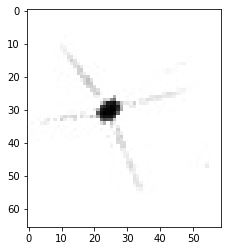

In [6]:
# Start with an infinitely large number
value_1 = math.inf
value_2 = math.inf
sum_1 = 0
sum_2 = 0
count = 0

# This checks for the lowest image size in the first and second dimension
for image in train_data:
    count+=1
    sum_1 += image.shape[0]
    sum_2 += image.shape[1]
    if image.shape[0] < value_1:
        
        value_1 = image.shape[0]
        hold_1 = image.shape
    if image.shape[1] < value_2:
        
        value_2 = image.shape[0]
        hold_2 = image.shape
        
sum_11 = sum_1 / count
sum_22 = sum_2 / count

print(f'Average dimensions: {sum_11}, {sum_22}')

plt.imshow(train_data[0], cmap = 'gray')

print(f'Lowest first dimension image {hold_1}')
print(f'Lowest second dimension image {hold_2}')

(32, 32, 1)


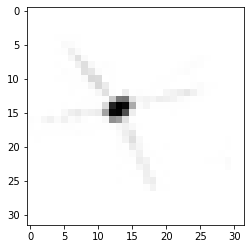

In [7]:
# Create an empty list for the training data
train_data_resized = []

# Loop through the images in the training data and resize them to the lowest shape in the dataset, 
# add a third dimension of 1 to the images and then append the image to the 'train_data_resized' list
for image in train_data:
    img = cv2.resize(image, dsize = (32, 32), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(img, axis = 2)
    train_data_resized.append(img)

# Test if the image is resized and show the image
print(train_data_resized[0].shape)
plt.imshow(train_data_resized[0], cmap = 'gray')

#Split the data into 70% training and 30% validation
im_train, im_val, lab_train, lab_val = train_test_split(train_data_resized, train_labels_one_hot, train_size=0.7, random_state=1265599650)

In [8]:
# Convert the data to numpy arrays, so tensorflow can use them
image_train = np.array(im_train)
label_train = np.array(lab_train)
image_val = np.array(im_val)
label_val = np.array(lab_val)

# Test if the shapes are correct
print(image_train.shape)
print(label_train.shape)
print(image_val.shape)
print(label_val.shape)

(21235, 32, 32, 1)
(21235, 121)
(9101, 32, 32, 1)
(9101, 121)


## Convolutional network

We use the function 'train_and_evaluate' which, obviously, trains our model and then evaluates the trained model on the validation data. This function was reused from the CIFAR-assignment from module 6 of ML2.

Y_ints line: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [9]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)
    
    y_ints = [y.argmax() for y in label_train]
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_ints), y = y_ints)
    
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")
    

## The actual model

We start with a very simple convolutional neural network, with 2 convolutional layers, both with pooling afterwards, and one dense layer. kernelsize, amount of filters, amount of nodes are specified in the code cell. This first version of the model gives us a validation accuracy of approximately 64%

In [ ]:
first_layer_filters = 32
second_layer_filters = 64
third_layer_filters = 128
fourth_layer_filters = 256

kernelsize = (3,3)
inputshape = (32,32, 1)
first_hidden_layer_nodes = 256
second_hidden_layer_nodes = 128
output_nodes = 121
# optimizer = 'adam'
optimizer = tf.keras.optimizers.Adam(lr=0.00001)

model_1 = models.Sequential()

model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same', input_shape = inputshape))
model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same'))
model_1.add(layers.MaxPooling2D((2, 2)))


model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same'))
model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same'))
model_1.add(layers.MaxPooling2D((2, 2)))


model_1.add(layers.Conv2D(third_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same'))
model_1.add(layers.Conv2D(third_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same'))
model_1.add(layers.MaxPooling2D((2, 2)))


model_1.add(layers.Conv2D(fourth_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same'))
model_1.add(layers.Conv2D(fourth_layer_filters, kernelsize, activation = layers.LeakyReLU(alpha=0.1), padding = 'same'))
model_1.add(layers.MaxPooling2D((2, 2)))


model_1.add(layers.Flatten())

model_1.add(layers.Dense(first_hidden_layer_nodes, activation = layers.LeakyReLU(alpha=0.1)))
model_1.add(layers.Dropout(0.15))
model_1.add(layers.Dense(second_hidden_layer_nodes, activation = layers.LeakyReLU(alpha=0.1)))
model_1.add(layers.Dropout(0.15))
model_1.add(layers.Dense(output_nodes, activation = 'softmax'))


train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 40, augment = {'horizontal_flip':  True, 'vertical_flip': True, 'rotation_range': 0.15, 'zoom_range': 0.15})

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 664 steps, validate for 285 steps
Epoch 1/40
664/664 [==============================] - 6s 9ms/step - loss: 3.7033 - accuracy: 0.1483 - val_loss: 2.8345 - val_accuracy: 0.2818
Epoch 2/40
664/664 [==============================] - 5s 8ms/step - loss: 2.6121 - accuracy: 0.3145 - val_loss: 2.2186 - val_accuracy: 0.3902
Epoch 3/40
664/664 [==============================] - 6s 8ms/step - loss: 2.2290 - accuracy: 0.3936 - val_loss: 1.9559 - val_accuracy: 0.4405
Epoch 4/40
664/664 [==============================] - 5s 8ms/step - loss: 2.0086 - accuracy: 0.4407 - val_loss: 1.8687 - val_accuracy: 0.4720
Epoch 5/40
664/664 [==============================] - 5s 8ms/step - loss: 8103.4726 - accuracy: 0.3479 - val_loss: 209.9637 - val_accuracy: 0.0732
Epoch 6/40
664/664 [==============================] - 5s 8ms/step - loss: 71.1527 - accuracy: 0.0508 - val_loss: 25.8736 - val_accuracy: 0.0527
Epoch 7/40
664/664 [==============================] - 5s 8ms/step - loss: 35.2763 - accuracy: 0.0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bramh\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bramh\AppData\Local\Temp/ipykernel_6872/1427779340.py", line 45, in <module>
    train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 40, augment = {'horizontal_flip':  True, 'vertical_flip': True, 'rotation_range': 0.15, 'zoom_range': 0.15})
  File "C:\Users\bramh\AppData\Local\Temp/ipykernel_6872/331437690.py", line 15, in train_and_evaluate
    validation_data=val_gen.flow(val_x, val_y))
  File "C:\Users\bramh\anaconda3\envs\progLab\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\bramh\anaconda3\envs\progLab\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bramh\anaconda3\envs\progLab\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bramh\AppData\Local\Temp/ipykernel_6872/1427779340.py", line 45, in <module>
    train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 40, augment = {'horizontal_flip':  True, 'vertical_flip': True, 'rotation_range': 0.15, 'zoom_range': 0.15})
  File "C:\Users\bramh\AppData\Local\Temp/ipykernel_6872/331437690.py", line 15, in train_and_evaluate
    validation_data=val_gen.flow(val_x, val_y))
  File "C:\Users\bramh\anaconda3\envs\progLab\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\bramh\anaconda3\envs\progLab\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\

In [ ]:
model_1.summary()

https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/